http://aishack.in/tutorials/labelling-connected-components-example/
https://courses.cs.washington.edu/courses/cse576/book/ch3.pdf   

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os


In [2]:
hm = 'img'
coins = []
for i in os.listdir(hm):
    if 'coins' in i:
        coins.append(i)

In [3]:
from PIL import Image
im = Image.open(os.path.join(hm,coins[0]))
im = np.array(im.resize((300,300),Image.ANTIALIAS))

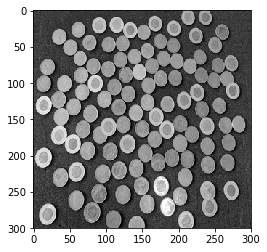

In [4]:
bw_im = np.mean(im,axis=2)/255

plt.imshow(bw_im,**{'cmap':'gray'})

In [5]:
bw_im.min(),bw_im.max()

(0.0, 1.0)

In [6]:
def img_histogram(bw_im,plot=True):
    bw_im = bw_im*100
    
    MaxVal = bw_im.max()
    MaxRow,MaxCol = bw_im.shape

    H = np.zeros(100)
    
    for i in range(MaxRow):
        for j in range(MaxCol):
            H[int(bw_im[i,j]-1)]+=1
    
    if plot==True:
        plt.title('Image Hstogram (black/white)')
        plt.plot(np.arange(100)/100,H)
        
    return H

In [7]:
def kernel(mode):
    if mode=='fd':
        gx = np.array([[0,0,0],[-1,0,1],[0,0,0]])
        gy = gx.T
        g = np.dstack((gx,gy))
    if mode=='sobel':
        gx = np.array([[-1,0,1],[-2,0,2],[-1,0,1]])
        gy = gx.T
        g = np.dstack((gx,gy))
    if mode=='laplacian':
        gx = np.array([[1,1,1],[1,8,1],[1,1,1]])
        gy = gx.T
        g = np.dstack((gx,gy))
    if mode=='mean':
        gx = np.ones((3,3))*1/9
        g = np.dstack((gx,gx))
    if mode=="gaussian":
        gx = [[0.077847,0.123317,0.077847],
[0.123317,0.195346,0.123317],
[0.077847,0.123317,0.077847]]
        g = np.dstack((gx,gx))

    return g

def get_im2col_indices(x_shape, field_height, field_width, p_x=1,p_y=1, stride=1):
    # First figure out what the size of the output should be
    _, C, H, W = x_shape
    assert (H + 2 * p_x - field_height) % stride == 0
    assert (W + 2 * p_y - field_height) % stride == 0
    out_height = int((H + 2 * p_x - field_height) / stride + 1)
    out_width = int((W + 2 * p_y - field_width) / stride + 1)

    i0 = np.repeat(np.arange(field_height), field_width)
    i0 = np.tile(i0, C)
    i1 = stride * np.repeat(np.arange(out_height), out_width)
    j0 = np.tile(np.arange(field_width), field_height * C)
    j1 = stride * np.tile(np.arange(out_width), out_height)
    i = i0.reshape(-1, 1) + i1.reshape(1, -1)
    j = j0.reshape(-1, 1) + j1.reshape(1, -1)

    k = np.repeat(np.arange(C), field_height * field_width).reshape(-1, 1)

    return (k, i, j)

def conv2d(im,g,stride=1,C=3):
    im = np.repeat(im[np.newaxis,:,:],2,axis=0)

    g = np.moveaxis(g,2,0)
    
    im = im[:,np.newaxis,:,:]
    N,_,H,W = im.shape
    _,h,w = g.shape
    
    stride=1
    h_pad = int((H*(stride-1)-stride+h)/2)
    w_pad = int((W*(stride-1)-stride+w)/2)

    k,i,j = get_im2col_indices((N,1,H,W), h, w, p_x=h_pad,p_y=w_pad, stride=1)

    im_padded = np.pad(im,((0,0),(0,0),(h_pad,h_pad),(w_pad,w_pad)),'mean')
    cols = im_padded[:,k,i,j]
    

    g = g.reshape((N,-1))

    
    sol = np.squeeze(np.matmul(g[:,np.newaxis,:],cols))
    
    return sol.reshape(N,H,W)


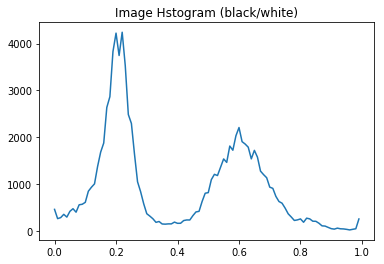

In [8]:
_ = img_histogram(bw_im)

In [9]:
norm = lambda x:(x - x.min())/(x.max()-x.min())

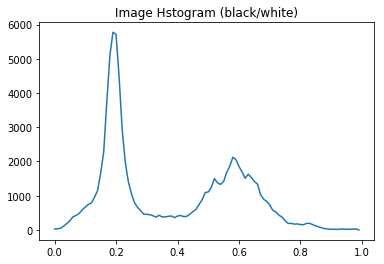

In [10]:
g = kernel('gaussian')
smth_im = conv2d(bw_im,g)[0]
smth_im = conv2d(bw_im,kernel('mean'))[0]
_ = img_histogram(norm(smth_im))

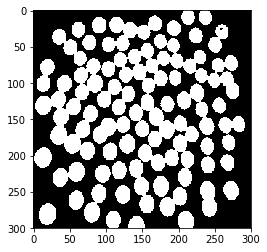

In [11]:
MaxRow,MaxCol = bw_im.shape
bw_mask = np.zeros((MaxRow,MaxCol))
bw_mask = (smth_im<1)&(smth_im>0.4)*1
plt.imshow(bw_mask,**{'cmap':'gray'})

In [12]:
from tqdm import tnrange,tqdm_notebook
from time import sleep

def recursive_connected_components(B):
    LB = -B
    label = 0
    LB = find_components(LB,label)
    return LB
    
def find_components(LB,label):
    MaxRow,MaxCol = LB.shape
    for L in tnrange(MaxRow):
        for P in range(MaxCol):
            if LB[L,P]==-1.0:
                label+=1
                LB = search(LB,label,L,P)
                #sleep(.01)
    return LB

def search(LB,label,L,P):
    
    LB[L,P] = label
    LB_padded = np.pad(LB,((1,1),(1,1)),'constant')
    
    Nset = LB_padded[L:L+3,P:P+3]
    
    
    for i in range(3):
        for j in range(3):
            if (i==1)&(j==1):
                    continue
            if Nset[i,j]==-1:
                if (L-1+i<0)|(P-1+j<0):
                    continue
                
                else:
                    LB=search(LB,label,L-1+i,P-1+j)
    return LB
    

In [29]:
import pylab as pl
from IPython import display as dp
import time

def plot_masks(laballed_mask):
    for i in np.unique(labelled_mask):

        pl.title('mask:{}'.format(i))

        pl.imshow(labelled_mask==i)
        
        pl.savefig('img/coin_data/'+'mask_'+str(i))



        dp.clear_output(wait=True)

        dp.display(pl.gcf())

        pl.gcf().clear()

        time.sleep(1.0)


In [21]:
import sys
sys.setrecursionlimit(15000)

B = bw_mask
labelled_mask = recursive_connected_components(B)

HBox(children=(IntProgress(value=0, max=300), HTML(value='')))

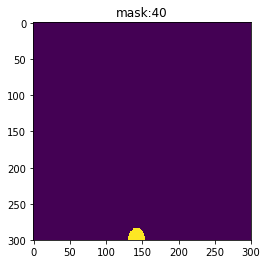

In [30]:
plot_masks(labelled_mask)

In [31]:
ls img/coin_data

mask_0.png   mask_16.png  mask_22.png  mask_29.png  mask_35.png  mask_4.png
mask_10.png  mask_17.png  mask_23.png  mask_2.png   mask_36.png  mask_5.png
mask_11.png  mask_18.png  mask_24.png  mask_30.png  mask_37.png  mask_6.png
mask_12.png  mask_19.png  mask_25.png  mask_31.png  mask_38.png  mask_7.png
mask_13.png  mask_1.png   mask_26.png  mask_32.png  mask_39.png  mask_8.png
mask_14.png  mask_20.png  mask_27.png  mask_33.png  mask_3.png   mask_9.png
mask_15.png  mask_21.png  mask_28.png  mask_34.png  mask_40.png


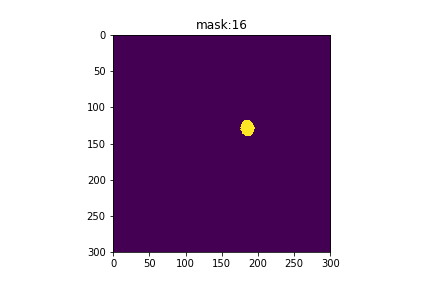

In [32]:
Image.open('img/coin_data/mask_16.png')